In [1]:
from platform import python_version
print(python_version())

3.7.10


A: The usage of the data set is unrestricted. But you should provide the link to our original download site, acknowledge the NIH Clinical Center and provide a citation to our CVPR 2017 paper

A: ‘No finding’ means the 14 listed disease patterns are not found in the image. 

https://www.kaggle.com/nih-chest-xrays/data

Citations
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

NIH News release: NIH Clinical Center provides one of the largest publicly available chest x-ray datasets to scientific community

Original source files and documents: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345

### Context Behind Dataset for Final Writeup:

Dataset was gathered by the NIH and contains over 100,000 anonymized chest x-ray images from more than 30,000 patients.  

# Goal
The goal is to use a simple model to classify x-ray images in Keras

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
import tensorflow

In [4]:
all_xray_df = pd.read_csv('../data/Data_Entry_2017.csv')
folderlist = glob(os.path.join('../data', 'images*'))
imglist = []
for folder in folderlist:
    tmp = glob(os.path.join(folder, "images", "*.png"))
    imglist += tmp
all_image_paths = {os.path.basename(x): x for x in imglist}
#{k:all_image_paths[k] for k in all_image_paths.keys()[:5]}
list(all_image_paths.items())[:4]
# all_image_paths = {os.path.basename(x): x for x in 
#                    glob(os.path.join('.', 'data', 'images*', '*.png'))}



[('00018942_001.png', '../data/images_009/images/00018942_001.png'),
 ('00020323_001.png', '../data/images_009/images/00020323_001.png'),
 ('00018730_001.png', '../data/images_009/images/00018730_001.png'),
 ('00019551_000.png', '../data/images_009/images/00019551_000.png')]

In [5]:
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
num_selected = 10000
tmp = {key: all_image_paths[key] for key in sorted(list(all_image_paths.keys()))[num_selected:]}
print(list(tmp.items())[:4])
all_xray_df['path'] = all_xray_df['Image Index'][num_selected:].map(tmp.get)
all_xray_df = all_xray_df[num_selected:]
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120
[('00002587_005.png', '../data/images_002/images/00002587_005.png'), ('00002588_000.png', '../data/images_002/images/00002588_000.png'), ('00002589_000.png', '../data/images_002/images/00002589_000.png'), ('00002589_001.png', '../data/images_002/images/00002589_001.png')]


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
53803,00013592_009.png,No Finding,9,13592,60,M,PA,2822,2991,0.143,0.143,NaN,../data/images_006/images/00013592_009.png
41219,00010677_024.png,Fibrosis|Infiltration|Pneumothorax,24,10677,56,F,AP,2500,2048,0.168,0.168,NaN,../data/images_005/images/00010677_024.png
87333,00021567_001.png,Infiltration,1,21567,20,M,PA,2992,2991,0.143,0.143,NaN,../data/images_010/images/00021567_001.png


In [6]:
label_counts = all_xray_df['Finding Labels'].value_counts()
label_counts

No Finding                                                                54652
Infiltration                                                               8734
Atelectasis                                                                3848
Effusion                                                                   3659
Nodule                                                                     2495
Mass                                                                       2015
Pneumothorax                                                               1972
Effusion|Infiltration                                                      1511
Atelectasis|Infiltration                                                   1237
Consolidation                                                              1199
Atelectasis|Effusion                                                       1091
Pleural_Thickening                                                         1004
Cardiomegaly                            

# Preprocessing Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

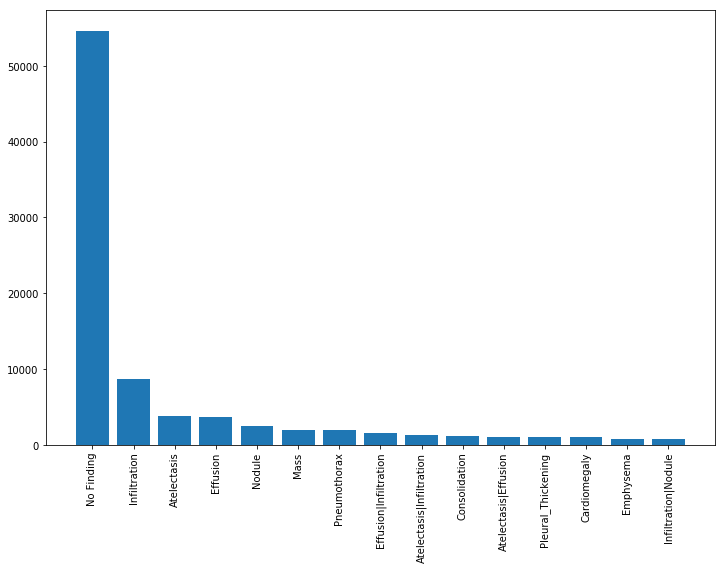

In [7]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [8]:
#all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
16451,00004381_045.png,Cardiomegaly|Effusion,45,4381,27,M,PA,2678,2873,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67421,00016649_007.png,No Finding,7,16649,56,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
74961,00018385_009.png,No Finding,9,18385,62,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

### Clean categories
Since we have too many categories, we can prune a few out by taking the ones with only a few examples

In [10]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (14) [('Atelectasis', 10670), ('Cardiomegaly', 2476), ('Consolidation', 4271), ('Edema', 2150), ('Effusion', 12410), ('Emphysema', 2295), ('Fibrosis', 1407), ('Infiltration', 18291), ('Mass', 5454), ('No Finding', 54652), ('Nodule', 5887), ('Pleural_Thickening', 3060), ('Pneumonia', 1296), ('Pneumothorax', 4862)]


In [11]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
39466,00010338_010.png,Cardiomegaly|Effusion,10,10338,70,M,PA,2942,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10908,00002839_003.png,No Finding,3,2839,10,M,PA,2322,1750,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
98118,00025899_000.png,No Finding,0,25899,49,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [12]:
for c_label, s_count in zip(all_labels, np.mean(all_xray_df[all_labels].values,0)):
    print('%s: %f' % (c_label, s_count))
arrivals=np.array(np.mean(all_xray_df[all_labels].values,0))
arrivals=arrivals/arrivals.sum(axis=0,keepdims=True)
print(arrivals)

Atelectasis: 0.104485
Cardiomegaly: 0.024246
Consolidation: 0.041823
Edema: 0.021054
Effusion: 0.121524
Emphysema: 0.022474
Fibrosis: 0.013778
Infiltration: 0.179113
Mass: 0.053408
No Finding: 0.535174
Nodule: 0.057648
Pleural_Thickening: 0.029965
Pneumonia: 0.012691
Pneumothorax: 0.047611
[0.08259729 0.01916691 0.03306214 0.01664331 0.09606676 0.01776577
 0.01089169 0.14159203 0.04221983 0.42306531 0.04557172 0.02368769
 0.01003244 0.03763711]


In [13]:
print(all_xray_df[all_labels].sum())

Atelectasis           10670.0
Cardiomegaly           2476.0
Consolidation          4271.0
Edema                  2150.0
Effusion              12410.0
Emphysema              2295.0
Fibrosis               1407.0
Infiltration          18291.0
Mass                   5454.0
No Finding            54652.0
Nodule                 5887.0
Pleural_Thickening     3060.0
Pneumonia              1296.0
Pneumothorax           4862.0
dtype: float64


# Label the type of each image and create a training data-set that is balanced across all image types


In [14]:
def image_type(X):
    if any(item =='Pneumothorax' for item in X):
        return 1
    elif any(item =='Emphysema' for item in X):
        return 2
    elif any(item =='Pneumonia' for item in X):
        return 3
    elif any(item =='Edema' for item in X):
        return 4
    elif any(item =='Consolidation' for item in X):
        return 5
    elif any(item =='Effusion' for item in X):
        return 6
    elif any(item =='Infiltration' for item in X):
        return 7
    elif any(item =='Atelectasis' for item in X):
        return 8
    elif any(item =='Cardiomegaly' for item in X):
        return 9
    elif any(item =='Pleural_Thickening' for item in X):
        return 10
    elif any(item =='Fibrosis' for item in X):
        return 11
    elif any(item =='Mass' for item in X):
        return 12
    elif any(item =='Nodule' for item in X):
        return 13
    else:
        return 14
def rank_disease(item):
    if item =='Pneumothorax':
        return 1
    elif item =='Emphysema':
        return 2
    elif item =='Pneumonia':
        return 3
    elif item =='Edema':
        return 4
    elif item =='Consolidation':
        return 5
    elif item =='Effusion':
        return 6
    elif item =='Infiltration':
        return 7
    elif item =='Atelectasis':
        return 8
    elif item =='Cardiomegaly':
        return 9
    elif item =='Pleural_Thickening':
        return 10
    elif item =='Fibrosis':
        return 11
    elif item =='Mass':
        return 12
    elif item =='Nodule':
        return 13
    else:
        return 14

# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [15]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
from itertools import chain
all_xray_df['Type']=all_xray_df['Finding Labels'].map(lambda x: image_type(x.split('|')))

In [16]:
print(all_xray_df[['Type','Finding Labels']].sample(10))


        Type                   Finding Labels
69641     14                       No Finding
62951     14                       No Finding
44151     14                       No Finding
22540     14                       No Finding
26974      7  Infiltration|Pleural_Thickening
37644      6            Cardiomegaly|Effusion
109866     7                     Infiltration
48858      2                   Emphysema|Mass
93690     14                       No Finding
84536      8                      Atelectasis


In [17]:
print(all_xray_df['Type'].value_counts())

14    54740
7     12078
6      9474
1      4862
8      4577
5      3758
13     2501
12     2410
4      1793
2      1602
10     1360
3      1243
9      1043
11      679
Name: Type, dtype: int64


In [18]:
print(all_xray_df[all_labels].sum())

Atelectasis           10670.0
Cardiomegaly           2476.0
Consolidation          4271.0
Edema                  2150.0
Effusion              12410.0
Emphysema              2295.0
Fibrosis               1407.0
Infiltration          18291.0
Mass                   5454.0
No Finding            54652.0
Nodule                 5887.0
Pleural_Thickening     3060.0
Pneumonia              1296.0
Pneumothorax           4862.0
dtype: float64


In [19]:
from sklearn.model_selection import train_test_split
train_df, valid_test_df = train_test_split(all_xray_df, 
                                   test_size = 0.5, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Type'])

In [20]:
valid_df, test_df = train_test_split(valid_test_df, 
                                   test_size = 0.5, 
                                   random_state = 2018,
                                   stratify = valid_test_df['Type'])

In [21]:
print('train', train_df.shape, 'validation', valid_df.shape,'test', test_df.shape)

train (51060, 30) validation (25530, 30) test (25530, 30)


In [22]:
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabelT'] = train_df['Type']
print(train_df.sample(3))

            Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
74720  00018356_005.png       Effusion            5       18356           49   
17858  00004808_097.png     No Finding           97        4808           38   
68282  00016842_004.png     No Finding            4       16842           48   

      Patient Gender View Position  OriginalImage[Width  Height]  \
74720              M            PA                 2048     2500   
17858              M            AP                 2500     2048   
68282              M            AP                 2500     2048   

       OriginalImagePixelSpacing[x  ...  Mass  No Finding Nodule  \
74720                        0.168  ...   0.0         0.0    0.0   
17858                        0.168  ...   0.0         1.0    0.0   
68282                        0.168  ...   0.0         1.0    0.0   

       Pleural_Thickening  Pneumonia  Pneumothorax  \
74720                 0.0        0.0           0.0   
17858                 0.0

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
valid_df['newLabelT'] = valid_df['Type']
print(valid_df.sample(3))

            Image Index              Finding Labels  Follow-up #  Patient ID  \
26593  00006970_001.png                  No Finding            1        6970   
63123  00015605_031.png  Consolidation|Infiltration           31       15605   
51858  00013105_000.png                  No Finding            0       13105   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
26593           45              M            PA                 2500     2048   
63123           32              F            AP                 2500     2048   
51858           50              F            PA                 2992     2991   

       OriginalImagePixelSpacing[x  ...  Mass  No Finding Nodule  \
26593                        0.168  ...   0.0         1.0    0.0   
63123                        0.168  ...   0.0         0.0    0.0   
51858                        0.143  ...   0.0         1.0    0.0   

       Pleural_Thickening  Pneumonia  Pneumothorax  \
26593                 0.0  

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
test_df['newLabelT'] = test_df['Type']
print(test_df.sample(3))

             Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
48171   00012210_004.png     No Finding            4       12210           55   
106587  00028758_000.png     No Finding            0       28758           72   
104901  00028131_011.png     No Finding           11       28131           51   

       Patient Gender View Position  OriginalImage[Width  Height]  \
48171               M            PA                 2992     2991   
106587              M            PA                 2021     2021   
104901              M            AP                 3056     2544   

        OriginalImagePixelSpacing[x  ...  Mass  No Finding Nodule  \
48171                      0.143000  ...   0.0         1.0    0.0   
106587                     0.194311  ...   0.0         1.0    0.0   
104901                     0.139000  ...   0.0         1.0    0.0   

        Pleural_Thickening  Pneumonia  Pneumothorax  \
48171                  0.0        0.0           0.0   
106587     

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


AxesSubplot(0.125,0.125;0.775x0.755)


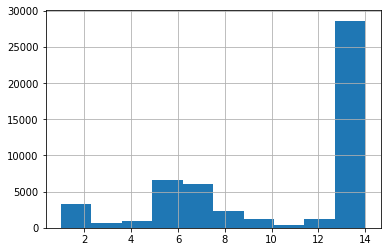

In [25]:
print(train_df['Type'].hist())

In [26]:
#from imblearn.over_sampling import SMOTE

In [27]:
#pip install -U git+https://github.com/scikit-learn-contrib/imbalanced-learn.git

In [28]:
from sklearn.preprocessing import LabelEncoder
y=train_df['Type']

In [29]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_res, y_res = ros.fit_resample(train_df, y)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


In [30]:
X_res.shape

(383180, 32)

In [31]:
train_df.shape

(51060, 32)

AxesSubplot(0.125,0.125;0.775x0.755)


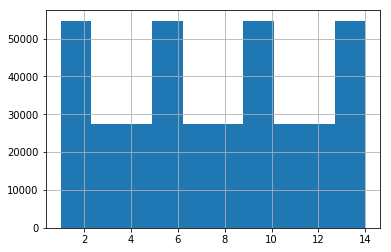

In [32]:
train_df=X_res
print(train_df['Type'].hist())

# Training the Model

In [33]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from keras import optimizers, callbacks, regularizers

Using TensorFlow backend.


In [34]:
from keras.preprocessing.image import ImageDataGenerator
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [35]:
def image_type_vector(X):
    set=X
    pet=set[set==1].index.tolist()
    return(image_type([all_labels[i] for i in pet]))

In [36]:
types=14
queues=4

In [37]:
def get_arrival_rates_types(data):
    types_test_data=pd.Series(data['Type'].value_counts().index)
    counts_types_test_data=pd.Series(data['Type'].value_counts())
    arrivals_types_test_data=counts_types_test_data/counts_types_test_data.sum(axis=0)
    return pd.DataFrame({'Type':types_test_data.values,'Arrival_Rates':arrivals_types_test_data.values}).sort_values('Type', ascending=True)['Arrival_Rates'].values   

In [38]:
get_arrival_rates_types(test_df)

array([0.04759107, 0.01570701, 0.01218175, 0.01758715, 0.03678026,
       0.09275362, 0.11829221, 0.04481003, 0.01022327, 0.01331767,
       0.00665883, 0.0235801 , 0.024481  , 0.53603604])

In [39]:
def get_costs_types(r):
    return [r**(types-rank-1) for rank in range(types)]

In [40]:
get_costs_types(2)

[8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]

In [41]:
def get_service_rates_types(rho):
    return [1/rho]*types

In [42]:
get_service_rates_types(0.9)

[1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112]

# Implementing Direct Feature-Based Triage

In [43]:
types=14

In [44]:
queues=4

In [45]:
r=1.5
rho=0.90

In [46]:
costs=get_costs_types(r)
arrivals=get_arrival_rates_types(all_xray_df)
service=get_service_rates_types(rho)

In [47]:
costs

[194.6195068359375,
 129.746337890625,
 86.49755859375,
 57.6650390625,
 38.443359375,
 25.62890625,
 17.0859375,
 11.390625,
 7.59375,
 5.0625,
 3.375,
 2.25,
 1.5,
 1.0]

In [48]:
arrivals

array([0.04761065, 0.01568743, 0.01217195, 0.01755778, 0.03679984,
       0.09277321, 0.11827262, 0.04481982, 0.01021347, 0.01331767,
       0.00664904, 0.02359969, 0.0244908 , 0.53603604])

In [49]:
service

[1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112,
 1.1111111111111112]

In [50]:
import tensorflow as tf

In [51]:
def queue_loss_tensor(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float16)
    y_pred = tf.cast(y_pred, tf.float16)
    #y_pred = tf.divide(y_pred,tf.reduce_sum(y_pred,axis=1,keepdims=True)+0.000000000001)
    pmat = tf.matmul(tf.transpose(y_true),y_pred)+0.007
    pmat = tf.divide(pmat,tf.reduce_sum(tf.transpose(y_true),axis=1,keepdims=True)+0.1)
    clambda = tf.reshape(tf.cast(tf.Variable(costs*arrivals),tf.float16),[1,types])
    rho = tf.reshape(tf.cast(tf.Variable(arrivals/service),tf.float16),[1,types])
    #clambda = tf.reshape(tf.Variable(costs*arrivals),[1,types])
    #rho = tf.reshape(tf.Variable(arrivals/service),[1,types])
    clambda_pmat = tf.matmul(clambda,pmat)
    rho_pmat = tf.matmul(rho,pmat)
    vec1=1-tf.cumsum(rho_pmat,axis=1)
    vec2=tf.roll(1-tf.cumsum(rho_pmat,axis=1),shift=1,axis=1)
    vec2=tf.tensor_scatter_nd_update(vec2,indices=[[0,0]],updates=[1])
    denom = tf.multiply(tf.math.reciprocal(vec1),tf.math.reciprocal(vec2))
    return tf.reshape(tf.reduce_sum(tf.multiply(clambda_pmat,denom)),[])
def queue_loss_tensor_try(y_true,y_pred):
    y_true = tf.cast(y_true+0.01, tf.float16)
    y_pred = tf.cast(y_pred, tf.float16)
    #y_pred = tf.divide(y_pred,tf.reduce_sum(y_pred,axis=1,keepdims=True)+0.000000000001)
    pmat = tf.matmul(tf.transpose(y_true),y_pred)
    pmat = tf.divide(pmat,tf.reduce_sum(pmat,axis=1,keepdims=True)+0.01)
    return tf.reshape(tf.reduce_mean(pmat),[])
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

In [52]:
def MakeModel1(IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(len(all_labels), activation = 'sigmoid'))
    return model
def MakeModel3(queues,IMG_SIZE, bs, channels=1):
    model = Sequential()
    base_mobilenet_model = MobileNet(input_shape =  (*IMG_SIZE, channels), #Need to define the shape here from IMG_SIZE
                                 include_top = False, weights = None)
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512,kernel_initializer=initializer))
    model.add(Dropout(0.5))
    model.add(Dense(queues, activation = 'softmax',kernel_regularizer=tf.keras.regularizers.l1(0.01),
                              activity_regularizer=tf.keras.regularizers.l2(0.01),kernel_initializer=initializer))
    return model

In [53]:
train_df['Type']=train_df['Type'].astype(str)
valid_df['Type']=valid_df['Type'].astype(str)
test_df['Type']=test_df['Type'].astype(str)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
class_labels=[str(X) for X in range(1,types+1)]

In [55]:
class_labels

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']

In [56]:
lr = 0.0005
syntheticBatch = 256
imageSize = (512, 512)
colorMode = 'rgb'
channels = 3
batchSize = 32
batch = int(256 / batchSize)
STEPS_PER_EPOCH = 1000
EPOCHS = 100
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.direct_r_1.5_rho_0.90.january_2022.hdf5".format('xray_class')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early]


train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'Type', 
                        class_mode = 'categorical',
                        classes=class_labels,
                        target_size = imageSize,
                         color_mode = colorMode,
                        batch_size = batchSize)

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                         directory=None,
                         x_col = 'path',
                        y_col = 'Type', 
                        class_mode = 'categorical',
                        classes=class_labels,
                        target_size = imageSize,
                         color_mode = colorMode,
                        batch_size = batchSize) # we can use much larger batches for evaluation

opt = tensorflow.keras.optimizers.Adam(
    learning_rate=lr,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

Found 383180 validated image filenames belonging to 14 classes.
Found 25530 validated image filenames belonging to 14 classes.


In [57]:
tf.keras.backend.clear_session()
import gc
gc.collect()

48

In [59]:
multi_disease_model_p = MakeModel1(imageSize, batchSize, channels)
multi_disease_model_p.load_weights("xray_class_weights.best.sequential.january_2022.hdf5")
multi_disease_model_p.add(Dense(queues, activation = 'softmax',kernel_initializer=initializer))

In [ ]:
multi_disease_model_p.compile(optimizer = opt, loss = queue_loss_tensor,
       run_eagerly=True,metrics = queue_loss_tensor)
history_p = multi_disease_model_p.fit_generator(train_gen,                           
              validation_data = valid_gen, 
              steps_per_epoch=1000,                                  
              epochs = 30, 
              callbacks = callbacks_list)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
1000/1000 [==============================] - 4438s 4s/step - loss: 63.6288 - queue_loss_tensor: 63.6288 - val_loss: 28.2604 - val_queue_loss_tensor: 28.2582

Epoch 00001: val_loss improved from inf to 28.26036, saving model to xray_class_weights.best.direct_r_1.5_rho_0.90.january_2022.hdf5
Epoch 2/30
 274/1000 [=======>......................] - ETA: 29:25 - loss: 50.2408 - queue_loss_tensor: 50.2408

In [61]:
history_p.history

{'loss': [57.8211555480957,
  52.105953216552734,
  51.10248565673828,
  51.22709274291992,
  55.698219299316406,
  87.56475067138672,
  68.38340759277344,
  62.473297119140625],
 'queue_loss_tensor': [57.8211555480957,
  52.105953216552734,
  51.10248565673828,
  51.22709274291992,
  55.698219299316406,
  87.56475067138672,
  68.38340759277344,
  62.473297119140625],
 'val_loss': [28.260364532470703,
  31.395292282104492,
  27.356199264526367,
  28.94000244140625,
  30.697481155395508,
  32.1657829284668,
  28.74149513244629,
  33.553375244140625],
 'val_queue_loss_tensor': [28.25823402404785,
  31.394208908081055,
  27.357437133789062,
  28.937000274658203,
  30.695724487304688,
  32.16362380981445,
  28.740875244140625,
  33.5489616394043]}

In [119]:
multi_disease_model_p.load_weights("xray_class_weights.best.direct_r_1.5_rho_0.90.january_2022.hdf5")

In [120]:
test_df.shape

(25530, 32)

In [122]:
test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=test_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'Type', 
                             class_mode = 'categorical',
                            classes = class_labels,
                            target_size = imageSize,
                             color_mode = colorMode,
                            batch_size = 2000))

Found 25530 validated image filenames belonging to 14 classes.


In [123]:
pred_Y = multi_disease_model_p.predict(test_X, batch_size = 32, verbose = True)

63/63 [==============================] - 18s 288ms/step


In [124]:
pred_Y = tf.one_hot(tf.argmax(np.array(pred_Y),axis=1), depth = 4)
pmat=np.dot(np.transpose(test_Y),pred_Y)

In [125]:
pmat_direct_r_1_8_rho_0_9=pmat/pmat.sum(axis=1,keepdims=True)

In [126]:
pmat_direct_r_1_8_rho_0_9

array([[0.        , 0.8217822 , 0.12871288, 0.04950495],
       [0.        , 0.68      , 0.24      , 0.08      ],
       [0.        , 0.90909094, 0.09090909, 0.        ],
       [0.        , 0.64705884, 0.29411766, 0.05882353],
       [0.        , 0.71153843, 0.1923077 , 0.09615385],
       [0.        , 0.59884834, 0.30038387, 0.10076775],
       [0.        , 0.8333333 , 0.16666667, 0.        ],
       [0.        , 0.61538464, 0.34615386, 0.03846154],
       [0.        , 0.47826087, 0.36956522, 0.1521739 ],
       [0.        , 0.65822786, 0.278481  , 0.06329114],
       [0.        , 0.72282606, 0.2173913 , 0.05978261],
       [0.        , 0.65163934, 0.2704918 , 0.07786885],
       [0.        , 0.53125   , 0.39583334, 0.07291666],
       [0.        , 0.        , 0.47368422, 0.5263158 ]], dtype=float32)

In [127]:
def queue_wait_cost(pmat,costs,arrivals,service):
    clambda = costs*arrivals
    rho = arrivals/service
    clambda_pmat = np.matmul(clambda,pmat)
    rho_pmat = np.matmul(rho,pmat)
    vec1=1-np.cumsum(rho_pmat)
    vec2=np.roll(1-np.cumsum(rho_pmat),1)
    vec2[0]=1
    denom = (1/vec1)*(1/vec2)
    return sum(clambda_pmat*denom)

In [128]:
queue_wait_cost(pmat_direct_r_1_8_rho_0_9,get_costs_types(1.5),get_arrival_rates_types(all_xray_df),get_service_rates_types(0.9))

508.64066620833864

In [129]:
del multi_disease_model_p